In [167]:
import json 
import os 
import ast
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from tabulate import tabulate


In [174]:
def get_results(filename):
    results = json.load(open(filename))
    analysis = {}
    for j in range(100):
        try:
            result = results[j]
            id = result['task_id']
            reward = result['reward']
            original_subtasks = len(ast.literal_eval(result['traj'][4]['content'].split('Subtasks solved: ')[1].strip()))
            subtasks_unsolved_before_last_step = ast.literal_eval(result['traj'][-2]['content'].split('Subtasks solved: ')[1].strip())
            subtasks_unsolved_after_last_step = 0
            for i in range(len(subtasks_unsolved_before_last_step)):
                if not subtasks_unsolved_before_last_step[i]:
                    subtasks_unsolved_after_last_step += 1

            analysis[id] = {'reward': reward, 'subtasks_unsolved': subtasks_unsolved_after_last_step, 'original_subtasks': original_subtasks}
        except:
            print(j)
    return analysis

In [169]:
def plot_algorithms_comparison(*algorithms_data, algorithm_names=None):
    """
    Plots comparison charts for multiple algorithms showing task outcome and reward logic.
    
    Args:
        *algorithms_data: Dictionaries with task info (reward, subtasks_unsolved, original_subtasks)
        algorithm_names: Optional list of names for labeling each algorithm
    """
    num_algos = len(algorithms_data)

    if algorithm_names is None:
        algorithm_names = [f"Algorithm {i+1}" for i in range(num_algos)]
    elif len(algorithm_names) != num_algos:
        raise ValueError("Length of algorithm_names must match number of algorithms_data")

    # Get union of all task IDs
    all_task_ids = sorted(set().union(*(data.keys() for data in algorithms_data)))
    x = np.arange(len(all_task_ids))

    def get_plot_data(data):
        heights, colors, dots_y, markers, marker_colors = [], [], [], [], []
        for tid in all_task_ids:
            if tid in data:
                d = data[tid]
                reward = d['reward']
                unsolved = d['subtasks_unsolved']
                total = d['original_subtasks']
                heights.append(total)

                # Determine color based on reward & unsolved consistency
                if reward == 1.0 and unsolved > 0:
                    colors.append('red')    # Mistaken reward
                elif reward == 0.0 and unsolved == 0:
                    colors.append('blue')   # Mistaken no reward
                else:
                    colors.append('gray')   # Correct behavior

                # Marker and color
                if reward == 1.0:
                    markers.append('✓')
                    marker_colors.append('green')
                else:
                    markers.append('✗')
                    marker_colors.append('red')

                dots_y.append(unsolved)
            else:
                heights.append(0)
                colors.append('white')
                dots_y.append(0)
                markers.append('')
                marker_colors.append('black')
        return heights, colors, dots_y, markers, marker_colors

    # Create subplots
    fig, axes = plt.subplots(num_algos, 1, figsize=(18, 5 * num_algos), sharex=True)
    if num_algos == 1:
        axes = [axes]

    for i, (data, ax, name) in zip(range(num_algos), zip(algorithms_data, axes, algorithm_names)):
        heights, colors, dots_y, markers, marker_colors = get_plot_data(data)

        ax.bar(x, heights, color=colors)
        ax.scatter(x, dots_y, color='black', zorder=5, s=30)

        # Markers: ✓ (green) or ✗ (red)
        for xi, hi, mark, mcolor in zip(x, heights, markers, marker_colors):
            if mark:
                ax.text(xi, hi + 0.2, mark, ha='center', va='bottom', fontsize=12, color=mcolor)

        ax.set_title(f"{name}")
        ax.set_ylabel("Original Subtasks")
        ax.grid(True, axis='y')
        ax.set_xticks(x)
        ax.set_xticklabels(all_task_ids, rotation=90, fontsize=9)

    axes[-1].set_xlabel("Task ID")

    # Add legend
    legend_elements = [
        Patch(facecolor='gray', label='✅ Correct outcome'),
        Patch(facecolor='red', label='❌ Reward=1 but Unsolved > 0'),
        Patch(facecolor='blue', label='❌ Reward=0 but Unsolved = 0'),
        Patch(facecolor='white', edgecolor='black', label='⛔ Missing Task'),
        Patch(facecolor='black', label='• Unsolved Subtasks')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right')

    # plt.tight_layout()
    plt.show()


In [177]:
def summarize_algorithm_results(*algorithms_data, algorithm_names=None, task_ids=None):
    """
    Summarizes classification outcomes for multiple algorithms.
    
    Args:
        *algorithms_data: Dicts with task_id -> {reward, subtasks_unsolved, original_subtasks}
        algorithm_names: Optional names for each algorithm
        task_ids: Optional list of task IDs to unify (default: union of all)
    """
    num_algos = len(algorithms_data)

    if algorithm_names is None:
        algorithm_names = [f"Algorithm {i+1}" for i in range(num_algos)]
    elif len(algorithm_names) != num_algos:
        raise ValueError("algorithm_names length must match algorithms_data length")

    # Gather all task IDs
    if task_ids is None:
        task_ids = sorted(set().union(*(data.keys() for data in algorithms_data)))

    summary = []
    
    for name, data in zip(algorithm_names, algorithms_data):
        correct = 0
        reward_but_pending = 0
        no_reward_no_pending = 0
        valid = 0
        missing = 0
        
        for tid in task_ids:
            if tid not in data:
                missing += 1
                continue
            entry = data[tid]
            reward = entry['reward']
            unsolved = entry['subtasks_unsolved']

            if reward == 1.0 and unsolved > 0:
                reward_but_pending += 1
            if reward == 0.0 and unsolved == 0:
                no_reward_no_pending += 1
            if reward == 1.0:
                correct += 1
            if reward == 0.0:
                valid += 1

        summary.append({
            "Algorithm": name,
            "✅ Correct": correct,
            "🟥 Correct but pending subtask": reward_but_pending,
            "🟦 Incorrect but no pending subtask": no_reward_no_pending,
            "⛔ Valid": valid,
            "Total Tasks": len(task_ids)
        })

    df = pd.DataFrame(summary)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    return df

c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9940 (\N{NO ENTRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


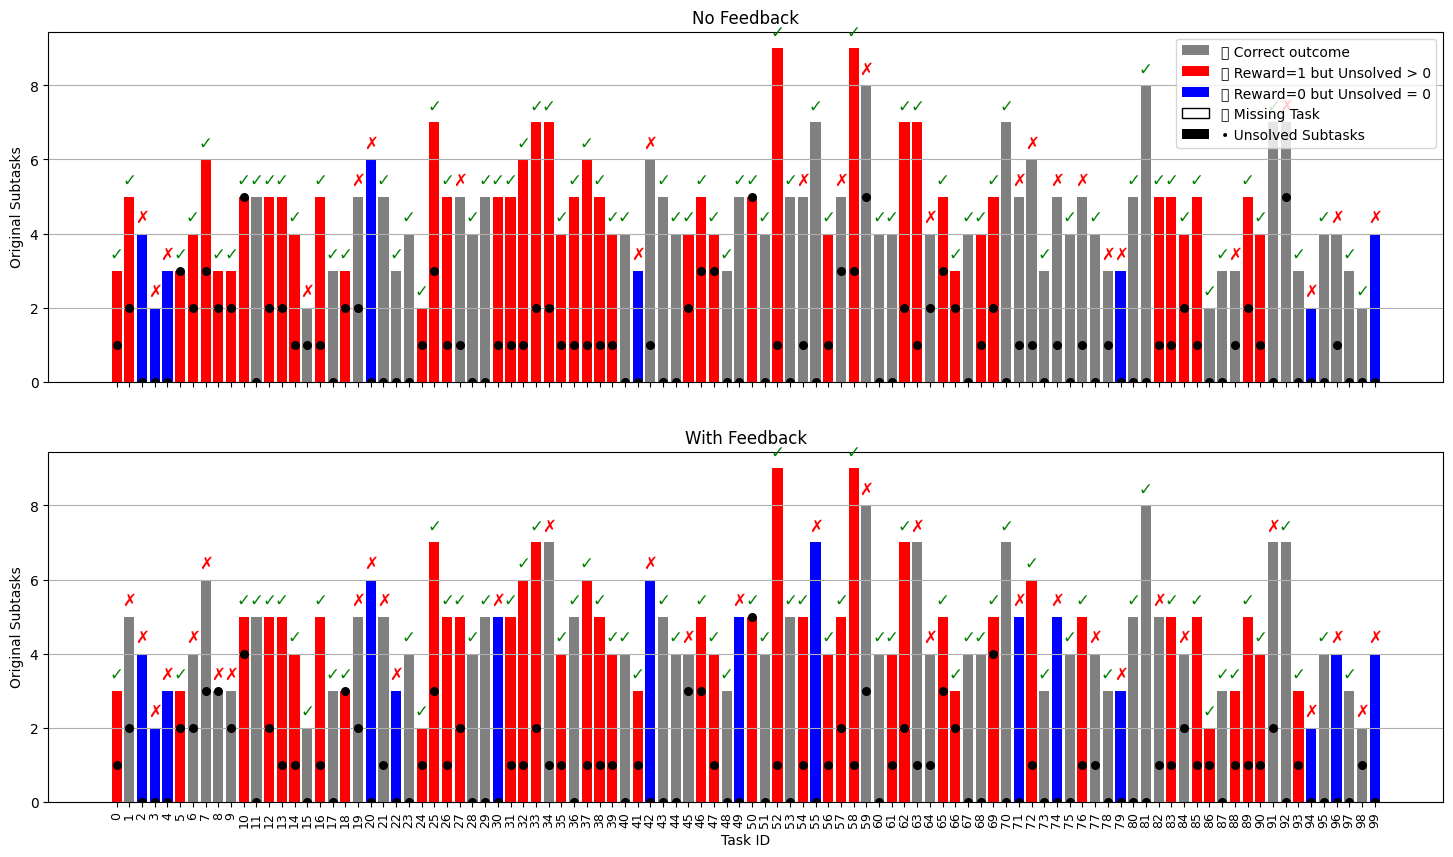

In [178]:
no_feedback = 'final_results/tool-calling-with-subtasks-check-none-0.1_range_0--1_user-none-llm_0714135412.json'
with_feedback = 'final_results/tool-calling-with-subtasks-feedback-none-0.1_range_0--1_user-none-llm_0715112655.json'
no_feedback_data = get_results(no_feedback)
with_feedback_data = get_results(with_feedback)
plot_algorithms_comparison(no_feedback_data, with_feedback_data, algorithm_names=['No Feedback', 'With Feedback'])

In [179]:
summarize_algorithm_results(no_feedback_data, with_feedback_data, algorithm_names=["No Feedback", "With Feedback"])


+---------------+------------+--------------------------------+-------------------------------------+----------+-------------+
|   Algorithm   | ✅ Correct | 🟥 Correct but pending subtask | 🟦 Incorrect but no pending subtask | ⛔ Valid | Total Tasks |
+---------------+------------+--------------------------------+-------------------------------------+----------+-------------+
|  No Feedback  |     76     |               45               |                  8                  |    24    |     100     |
| With Feedback |     68     |               42               |                 15                  |    32    |     100     |
+---------------+------------+--------------------------------+-------------------------------------+----------+-------------+


,Algorithm,✅ Correct,🟥 Correct but pending subtask,🟦 Incorrect but no pending subtask,⛔ Valid,Total Tasks
0,No Feedback,76,45,8,24,100
1,With Feedback,68,42,15,32,100
